In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import  cv2

# The primary idea is to maximise the loss on a certain image with minimal modifications 

## But for that we first have to know how does a model minimize loss first

* Learning step 1 - The raw image is passed through the model, and it returns a label accordingly (`pred`)
* Learning step 2 - The `pred` is then compared with the original `label` and a certain "difference" which is calculated with a fancy mathematical function depending upon the task at hand. 
> In our case it's `nn.CrossEntropyLoss()` because it's a classification  problem
* Learning step 3 - the weights are adjusted in the network based on the backropagated gradients
> The *change in the loss* for a *small change in an input weight* is called the gradient of that weight and is calculated using *backpropagation*  

$$gradient = \frac{\partial (loss)}{\partial (weight)}$$

Now in the normal learning process, the weights are adjusted with respect to the gradient in order to minimise loss.

But our objective is to maximise loss, and the key to that is **extracting the gradient**



> `empty_tensor.random_(x)` returns a a random distribution ranged from 0 to x-1


In [53]:
# loss func
loss = nn.CrossEntropyLoss()

## prediction
pred = torch.tensor([[1., 0.]], requires_grad=True)

## generate a random index either  (0 or 1) as the label
label = torch.empty(1, dtype=torch.long).random_(2)  ## 

## calculating the loss val 
oof = loss(pred, label)

print("predicted probability distribution of classes = ", pred.flatten().tolist())
print("actual index of class = ",label.item())
print("loss = ", oof)

predicted probability distribution of classes =  [1.0, 0.0]
actual index of class =  0
loss =  tensor(0.3133, grad_fn=<NllLossBackward>)


###  For our experiments, I'll use a pre trained model trained to classify animals from Minecraft

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 7, 5)
        self.pool = nn.MaxPool2d(3, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(7, 10, 5)
        
        self.fc1 = nn.Linear(10, 10)
        self.fc2 = nn.Linear(10, 8)
        self.fc3 = nn.Linear(8, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
hunter = Net()
hunter.zero_grad()
hunter.load_state_dict(torch.load("hunter.pt"))
hunter.eval()

Net(
  (conv1): Conv2d(3, 7, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
)

### Loading up a sample image and checking the model

In [23]:
def preprocess_image_for_model(img_path):
    im = cv2.imread("images/chicken.png")
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # convert to RGB color space 
    plt.imshow(im)
    im_moveaxis =  np.moveaxis(im, 2, 0) 
    input_tensor =  torch.from_numpy(im_moveaxis).unsqueeze(0).float()
    return input_tensor

Predicted label =  0


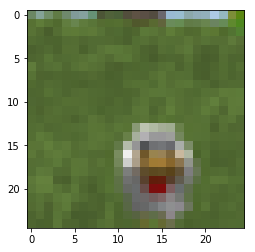

In [48]:
input_tensor = preprocess_image_for_model("images/chicken.png")
print ("Predicted label = ", torch.argmax(hunter(input_tensor)).item())

In [86]:
label = torch.zeros(1, dtype=torch.long)  ##
input_tensor.requires_grad = True
pred = hunter(input_tensor)
loss_val = loss(pred,label)
print("loss = ",loss_val.item())

loss =  9.727005090098828e-05


In [81]:
loss_val.backward()

In [88]:
data_grad = input_tensor.grad.data